# GLM-logistic-regression

This notebook contains a step-by-step guide to performing various forms of logistic regression.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from scipy.special import expit

from sklearn.datasets import make_classification

A logistic regression has a binary dependent variable $y$ (logical) that returns the probability of category membership given the independent variable $x$: P(y=1|x). Classification can then be implemented using a threshold, for instance P>0.5.

To go through logistic regression, I will simulate two datasets of uniform numbers with different means.

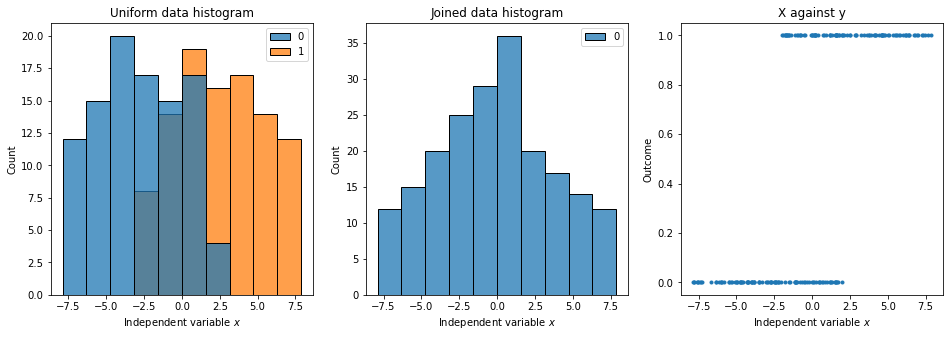

,x,y
0,-2.189652,0.0
1,-3.487403,0.0
2,-5.127026,0.0
3,0.275819,0.0
4,-3.482353,0.0


In [2]:
## Uniformly-distributed numbers

# parameters
stretch = 10 # not the variance
shift   = [-3, 3] 
n       = 100

# create data
x1 = stretch*np.random.rand(n) + shift[0]-stretch/2
x2 = stretch*np.random.rand(n) + shift[1]-stretch/2

y1 = np.zeros_like(x1)
y2 = np.ones_like(x2)

x = np.concatenate((x1,x2))
y = np.concatenate((y1,y2))

df = pd.DataFrame(data={'x':x, 'y':y})
x = x[:,np.newaxis]

# plot data
fig,ax = plt.subplots(1,3,figsize=(16,5))

sns.histplot((x1,x2), ax=ax[0])
ax[0].set_title('Uniform data histogram')
ax[0].set_xlabel('Independent variable $x$')

sns.histplot((x), ax=ax[1])
ax[1].set_title('Joined data histogram')
ax[1].set_xlabel('Independent variable $x$')

ax[2].plot(x, y, '.')
ax[2].set_title('X against y')
ax[2].set_xlabel('Independent variable $x$')
ax[2].set_ylabel('Outcome')

plt.show()

df.head()

Looking at these histograms, although there is overlap in the distributions of the two groups (categories), the data seems to be reasonably well divided along the variable $x$. The goal is to build a binary logistic regression that learns to make the class division. This model will return the probability that a specific data point $x_i$ will be categorised as $y_i$=1 (P(y=1|x)). 

# Logistic regression: natural logarithm of the odds ratio
A logigistic regression has the normal regression coefficients on the right hand side of the equation, but the natural logarithm of the odds ratio on the left hand side, i.e. the probability of an event occurring over an event not occurring, or the probability of group membership over the probability of not that group membership.

$$
\ln\frac{p}{1-p} = \beta_0x^0 + \beta_1x^2 + ... + \beta_kx^k
$$

The reason to take the logarithm of the probabilities is that the log of small values has a larger dynamic range and is easier to work with in optimisation problems.

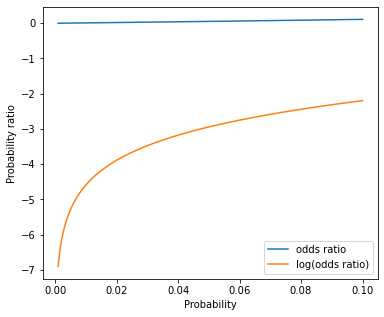

In [3]:
p = np.linspace(0.001,.1,1000)

fig,ax = plt.subplots(1,1,figsize=(6,5))
ax.plot(p, p/(1-p), label='odds ratio')
ax.plot(p, np.log(p/(1-p)), label='log(odds ratio)')

ax.set_xlabel('Probability')
ax.set_ylabel('Probability ratio')
ax.legend()
plt.show()

Solving the logistic function for $p$ returns the sigmoid function.

$$
\begin{aligned}
  \ln\frac{p}{1-p} &= \beta_0x^0 + \beta_1x^2 + ... + \beta_kx^k \\
  \ln\frac{p}{1-p} &= Z \\
  \frac{p}{1-p} &= e^{Z} \\
  p &= e^{Z}(1-p) \\
  p &= e^{Z}-e^{Z}p \\
  e^{Z} &= e^{Z}p + p \\
  e^{Z} &= p(1 + e^{Z}) \\
  p &= \frac{e^{Z}}{(1 + e^{Z})} \\
  p &= \frac{e^{Z}}{(1 + e^{Z})} \frac{e^{-Z}}{e^{-Z}}\\
  p &= \frac{1}{(1 + e^{-Z})} \\
\end{aligned}
$$


# Why the sigmoid function?

The sigmoid function is a "squashing" function. As $Z$ has a potentially infinite range {-Inf, +Inf}, it needs to be mapped to [0,1] so we can perform our classification. The Sigmoid function does that.

$$
\sigma(Z) = \frac{1}{1+exp(-Z)}
$$

This function returns a probability-like value, $0 \leq \sigma(Z) \leq 1$.

So, the model takes the input from variable $x$ and weights this input according to weight coefficients $\beta$. These two terms comprise the linear model $Z = \beta^Tx$. This is passed through a sigmoid function $\sigma(Z)$ to predict category $y$, the probability that $y_i=1$.

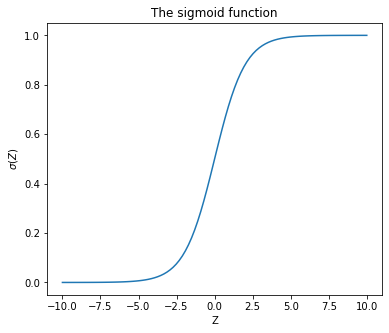

In [4]:
def sigmoid(z):
    """Return the logistic transform of z."""
    sigmoid = 1 / (1 + np.exp(-z)) 
    return sigmoid


z = np.linspace(-10,10,100)
p = sigmoid(z)

# plot data
fig,ax = plt.subplots(1,1,figsize=(6,5))
ax.plot(z,p)
ax.set_title('The sigmoid function')
ax.set_xlabel('Z')
ax.set_ylabel('$\sigma(Z)$')
plt.show()

Because of the nonlinearities in this model, it is impossible to use the closed form, analytic (left-inverse) solution we use in linear regression. Therefore, we need to define a cost function. This function will be used to check how well our model is performing. We will use iterative methods (gradient descent) to solve for the parameters that make the probabilities best match the dependent variable $y$, i.e. minimise the cost function.

In [5]:
# set up logistic regression 'manually'

class MyLogisticRegression:
    
    def __init__(self, df, x_cols, y_col, iterations=20000, learning_rate=0.001):
        self.df = df
        self.x_cols = x_cols
        self.y_col = y_col
        self.iterations = iterations
        self.learning_rate = learning_rate
        
    def sigmoid(self, z):
        return 1/(1+np.exp(-z))
    
    def cost(self, y, pred):
        # defining the cost function
        num_samples = np.shape(y)[0] # number of samples
        J = (1/num_samples) * np.sum( y@np.log(pred.T) + (1-y)@np.log(1-pred.T) ) 
        return J
    
    def train(self):
        
        num_param = len(self.x_cols)
        num_samples = self.df.shape[0] # number of samples
        
        # initialise paramater and bias with zeros
        w = np.zeros((num_param,1)) # column vector of coefficients
        b = 0
        
        # create design matrix and get y
        X = df['x'].to_numpy().reshape(num_samples,num_param) # design matrix with dependent variables, column vector
        y = self.df[self.y_col].to_numpy().reshape(num_samples,1) # independent variable

        # Keep track of cost function
        loss = [] 
                
        for i in range(self.iterations):
            
            # compute predictions 
            z = X@w + b
            pred = self.sigmoid(z)

            # compute cost
            cost = self.cost(y,pred) 
            loss.append(cost)
            
            # compute gradient
            dw = (1/num_samples) * X.T@(pred-y)
            db = (1/num_samples) * np.sum(pred-y, axis=0)

            # updated w and b
            w = w - self.learning_rate*dw
            b = b - self.learning_rate*db

        return {'W':w, 'b':b, 'loss':loss}

    def predict(self, X, W, b):
        
        pred = self.sigmoid(X@W + b)
        pred = [1 if prob >= 0.5 else 0 for prob in pred]
        return pred

Acuracy:  0.79
The model has intercept (bias) 1.25e-01 and slope coefficient 0.69 


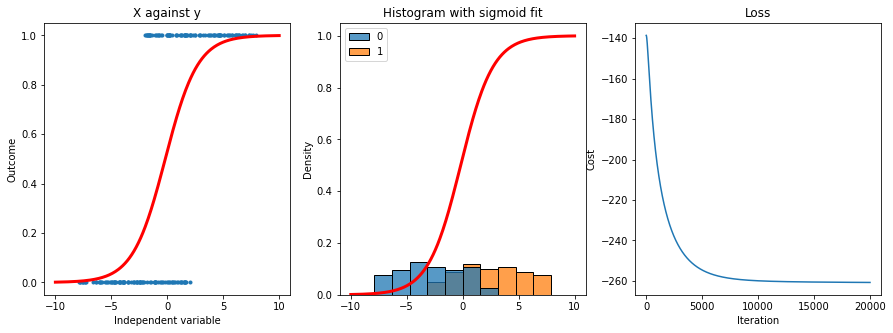

In [6]:
# set up model, train
lg = MyLogisticRegression(df, ['x'], ['y'])
model = lg.train()

# find predictions
X = df['x'].to_numpy().reshape(n*2,1)
pred = lg.predict(X, model['W'], model['b'])

# get coefficients
intercept = model['b'] # bias
slope = model['W']

print("Acuracy: ", np.array(pred == df.y).sum()/(n*2))
print(f'The model has intercept (bias) %.2e and slope coefficient %.2f ' %(intercept, slope))

# get the fitted sigmoid
x_test = np.linspace(-stretch+np.mean(shift), stretch+np.mean(shift), 300)
loss = expit(x_test * slope + intercept).ravel()

# plot
fig,ax = plt.subplots(1,3,figsize=(15,5))

# plot sigmoid fit
ax[0].plot(x, y, '.')
ax[0].plot(x_test, loss, color='red', linewidth=3)
ax[0].set_title('X against y')
ax[0].set_xlabel('Independent variable')
ax[0].set_ylabel('Outcome')

# plot sigmoid fit with histograms
sns.histplot((x1,x2), ax=ax[1],
    stat='density',
    multiple='layer',
    common_norm=False)
ax[1].set_title('Histogram with sigmoid fit')
ax[1].plot(x_test, loss, color='red', linewidth=3)

# plot cost function
ax[2].plot(model['loss'])
ax[2].set_title('Loss')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Cost')

plt.show()

We see that for negative values of $x$, the probability of $y=1$ is low and for large positive values of $x$ $P(y=1)$ is close to 1. For intermediate values of $x$, we find probabilities around 0.5. With each iteration of the algorithm, the Loss function converges to a minimum. 

Now lets use the built-in functionality of `sklearn.linear_model.LogisticRegression`.

# Use built-in function

The model has intercept (bias) 1.39e-01 and slope coefficient 0.69 
The data have grand average mean -0.15, with x1/x2 mean -2.84/2.53
Accuracy on training data: 0.785


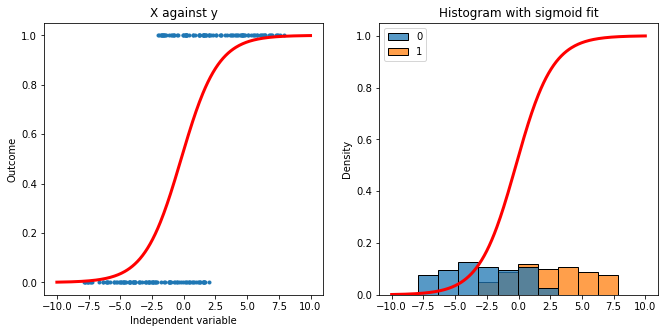

In [7]:
# First define the model
log_reg = LogisticRegression(penalty="none", fit_intercept=True)

#Then fit it to data
log_reg.fit(x, y)

intercept = log_reg.intercept_
slope = log_reg.coef_[0]

# evaluate the model 
print(f'The model has intercept (bias) %.2e and slope coefficient %.2f ' %(intercept, slope))
print(f'The data have grand average mean %.2f, with x1/x2 mean %.2f/%.2f' %(np.mean(x), np.mean(x1), np.mean(x2)))

# lets see how well the model predicted the outcome
y_hat = log_reg.predict(x)
accuracy = np.sum(y==y_hat)/(n*2)
print(f'Accuracy on training data: {accuracy}')

# plot the model
x_test = np.linspace(-stretch+np.mean(shift), stretch+np.mean(shift), 300)
loss = expit(x_test * slope + intercept).ravel()

fig,ax = plt.subplots(1,2,figsize=(11,5))

# plot sigmoid fit
ax[0].plot(x, y, '.')
ax[0].plot(x_test, loss, color='red', linewidth=3)
ax[0].set_title('X against y')
ax[0].set_xlabel('Independent variable')
ax[0].set_ylabel('Outcome')

# plot sigmoid fit with histograms
sns.histplot((x1,x2), ax=ax[1],
    stat='density',
    multiple='layer',
    common_norm=False)
ax[1].set_title('Histogram with sigmoid fit')
ax[1].plot(x_test, loss, color='red', linewidth=3)

plt.show()

# Logistic regression with multiple independent variables



In [8]:
num_samples = 500

x1 = np.random.rand(num_samples)*10
x2 = np.random.rand(num_samples)*2
df = pd.DataFrame(data={'x1': x1, 'x2': x2})

y = np.where(df['x2']*df['x1']>6, 1, 0)
y_idx = np.asarray((df['x2']*df['x1']>3) & (df['x2']*df['x1']<=6)).nonzero()
y[y_idx] = np.random.randint(low=0, high=2, size=np.shape(y_idx))
df['y'] = y
# df['y'] = np.where(df['x2']*df['x1']>5, 1, 0)
df.head()


,x1,x2,y
0,5.159582,0.189914,0
1,1.735981,0.122640,0
2,6.781850,1.454546,1
3,1.908246,1.648660,1
4,6.031802,0.365442,0


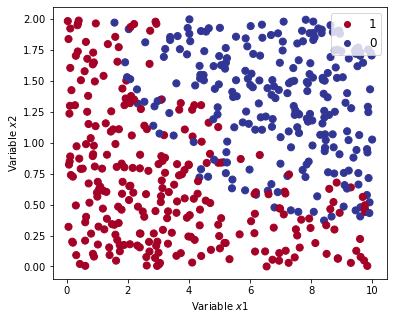

In [9]:
fig,ax = plt.subplots(1,1,figsize=(6,5))

scatter = ax.scatter(df.x1, df.x2, s=50, c=df.y, cmap='RdYlBu')
ax.legend(handles=scatter.legend_elements()[0], labels=['1','0'], 
           loc='upper right', fontsize=12)
ax.set_xlabel('Variable $x1$')
ax.set_ylabel('Variable $x2$')
plt.show()

In [10]:
# First define the model
log_reg = LogisticRegression(penalty="none", fit_intercept=True)

#Then fit it to data
log_reg.fit(df[['x1','x2']].to_numpy(), df['y'].to_numpy())

intercept = log_reg.intercept_
slope = log_reg.coef_[0]

print(slope)

# evaluate the model 
print(f'The model has intercept (bias) %.2e and slope coefficients {slope} ' %(intercept))

# lets see how well the model predicted the outcome
y_hat = log_reg.predict(df[['x1','x2']].to_numpy())
accuracy = np.sum(df['y']==y_hat)/(num_samples)
print(f'Accuracy on training data: {accuracy}')


[0.95985124 4.74070469]
The model has intercept (bias) -9.92e+00 and slope coefficients [0.95985124 4.74070469] 
Accuracy on training data: 0.874


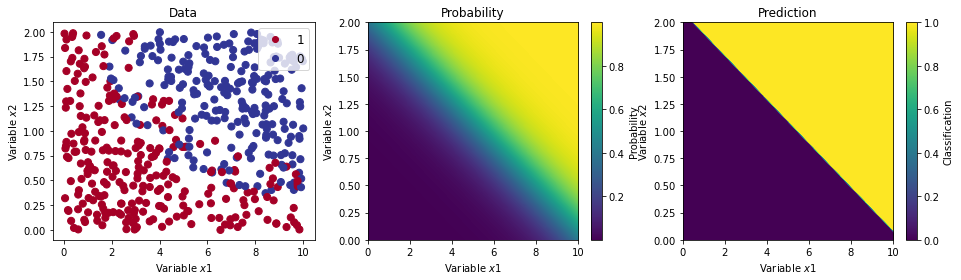

In [11]:
# evaluate the parameter space
x1 = np.linspace(0, 10, 1000)
x2 = np.linspace(0, 2, 200)

# in matrix form
X1,X2 = np.meshgrid(x1,x2)
X1 = X1.reshape(-1)
X2 = X2.reshape(-1)
X = np.array([X1,X2]).T

# predict
pred = log_reg.predict(X)
pred_proba = log_reg.predict_proba(X)[:,1]
pred = pred.reshape((len(x2),len(x1)))
pred_proba = pred_proba.reshape((len(x2),len(x1)))

# plot
fig,ax = plt.subplots(1,3,figsize=(16,4))

scatter = ax[0].scatter(df.x1, df.x2, s=50, c=df.y, cmap='RdYlBu')
ax[0].legend(handles=scatter.legend_elements()[0], labels=['1','0'], 
           loc='upper right', fontsize=12)
ax[0].set_xlabel('Variable $x1$')
ax[0].set_ylabel('Variable $x2$')
ax[0].set_title('Data')

pos = ax[1].imshow(pred_proba, 
                   origin='lower', 
                   aspect='auto', 
                   extent=(x1[0], x1[-1], x2[0], x2[-1])
                  )
ax[1].set_xlabel('Variable $x1$')
ax[1].set_ylabel('Variable $x2$')
ax[1].set_title('Probability')
fig.colorbar(pos, ax=ax[1], label='Probability')

pos = ax[2].imshow(pred, 
                   origin='lower', 
                   aspect='auto', 
                   extent=(x1[0], x1[-1], x2[0], x2[-1])
                  )
ax[2].set_xlabel('Variable $x1$')
ax[2].set_ylabel('Variable $x2$')
ax[2].set_title('Prediction')
fig.colorbar(pos, ax=ax[2], label='Classification')

plt.show()

# Adding a polynomial term


[ 1.07820494 14.29940117 -4.1573295 ]
The model has intercept (bias) -1.48e+01 and slope coefficients [ 1.07820494 14.29940117 -4.1573295 ] 
Accuracy on training data: 0.88


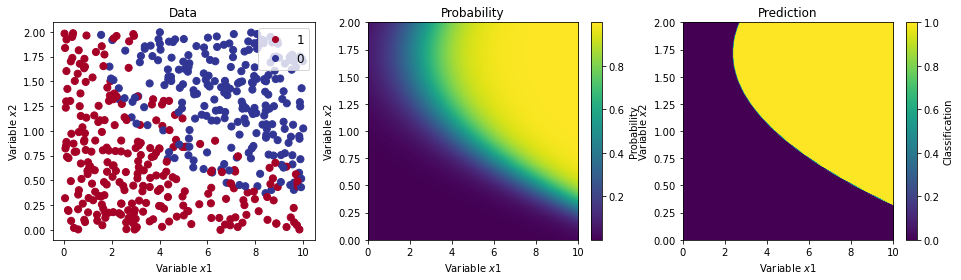

In [12]:
df['x2s'] = df['x2']**2

# First define the model
log_reg = LogisticRegression(penalty="none", fit_intercept=True)

#Then fit it to data
log_reg.fit(df[['x1','x2','x2s']].to_numpy(), df['y'].to_numpy())

intercept = log_reg.intercept_
slope = log_reg.coef_[0]

print(slope)

# evaluate the model 
print(f'The model has intercept (bias) %.2e and slope coefficients {slope} ' %(intercept))

# lets see how well the model predicted the outcome
y_hat = log_reg.predict(df[['x1','x2','x2s']].to_numpy())
accuracy = np.sum(df['y']==y_hat)/(num_samples)
print(f'Accuracy on training data: {accuracy}')

X2s = X2**2
X = np.array([X1,X2,X2s]).T

# predict
pred = log_reg.predict(X)
pred_proba = log_reg.predict_proba(X)[:,1]
pred = pred.reshape((len(x2),len(x1)))
pred_proba = pred_proba.reshape((len(x2),len(x1)))

# plot
fig,ax = plt.subplots(1,3,figsize=(16,4))

scatter = ax[0].scatter(df.x1, df.x2, s=50, c=df.y, cmap='RdYlBu')
ax[0].legend(handles=scatter.legend_elements()[0], labels=['1','0'], 
           loc='upper right', fontsize=12)
ax[0].set_xlabel('Variable $x1$')
ax[0].set_ylabel('Variable $x2$')
ax[0].set_title('Data')

pos = ax[1].imshow(pred_proba, 
                   origin='lower', 
                   aspect='auto', 
                   extent=(x1[0], x1[-1], x2[0], x2[-1])
                  )
ax[1].set_xlabel('Variable $x1$')
ax[1].set_ylabel('Variable $x2$')
ax[1].set_title('Probability')
fig.colorbar(pos, ax=ax[1], label='Probability')

pos = ax[2].imshow(pred, 
                   origin='lower', 
                   aspect='auto', 
                   extent=(x1[0], x1[-1], x2[0], x2[-1])
                  )
ax[2].set_xlabel('Variable $x1$')
ax[2].set_ylabel('Variable $x2$')
ax[2].set_title('Prediction')
fig.colorbar(pos, ax=ax[2], label='Classification')

plt.show()

# Links

- [Logistic regression with third categorical interaction term](https://towardsdatascience.com/an-introduction-to-logistic-regression-for-categorical-data-analysis-7cabc551546c)
- [Step-by-step multinomial logistic regression](https://medium.com/swlh/logistic-regression-simple-python-implementation-f3c2f8a8ee80)
